# Bisect and simplex with numba

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import bisect
from numba import jit, prange

from pyproximal.proximal import *
from pyproximal.projection import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

from pyproximal.proximal._Simplex_numba import bisect_jit, simplex_jit

In [2]:
os.getenv('NUMBA_NUM_THREADS')

'4'

## Bisect

In [3]:
def fun(mu, x, coeffs, scalar, lower, upper):
    return np.dot(coeffs, np.minimum(np.maximum(x - mu * coeffs, lower), upper)) - scalar

In [4]:
@jit(nopython=True)
def fun_jit1(mu, x, coeffs, scalar, lower, upper):
    return np.dot(coeffs, np.minimum(np.maximum(x - mu * coeffs, lower), upper)) - scalar

@jit(nopython=True, nogil=True)
def bisect_jit1(x, coeffs, scalar, lower, upper, bisect_lower, bisect_upper,
               maxiter, ftol, xtol):
    a, b = bisect_lower, bisect_upper
    fa = fun_jit1(a, x, coeffs, scalar, lower, upper)
    for iiter in range(maxiter):
        c = (a + b) / 2.
        if (b - a)/2 < xtol:
            return c
        fc = fun_jit1(c, x, coeffs, scalar, lower, upper)
        if np.abs(fc) < ftol:
            return c
        if np.sign(fc) == np.sign(fa):
            a = c
            fa = fc
        else:
            b = c
    return c

In [5]:
np.random.seed(0)
n = 10
lower = 0
upper = 10000000000
coeffs = np.ones(n)
x = np.random.normal(0, 1., n)

bisect_lower = -1
while fun(bisect_lower, x, coeffs, 1., lower, upper) < 0:
    bisect_lower *= 2

bisect_upper = 1
while fun(bisect_upper, x, coeffs, 1., lower, upper) > 0:
    bisect_upper *= 2
    
print(bisect_lower, bisect_upper)

mu = bisect(lambda mu: fun(mu, x, coeffs, 1., lower, upper), bisect_lower, bisect_upper, maxiter=100)
mu_jit = bisect_jit(x, coeffs, 1., lower, upper, bisect_lower, bisect_upper, 100, 1e-8, 1e-8)
print(mu, mu_jit)

-1 2
1.6241678451074222 1.6241678446531296


In [6]:
%timeit -n 20 -r 2 bisect(lambda mu: fun(mu, x, coeffs, 1., lower, upper), bisect_lower, bisect_upper, maxiter=100)
%timeit -n 20 -r 2 bisect_jit(x, coeffs, 1., lower, upper, bisect_lower, bisect_upper, 100, 1e-3, 1e-3)
%timeit -n 20 -r 2 bisect_jit1(x, coeffs, 1., lower, upper, bisect_lower, bisect_upper, 100, 1e-3, 1e-3)

263 µs ± 27.6 µs per loop (mean ± std. dev. of 2 runs, 20 loops each)
The slowest run took 5.36 times longer than the fastest. This could mean that an intermediate result is being cached.
8.22 µs ± 5.63 µs per loop (mean ± std. dev. of 2 runs, 20 loops each)
The slowest run took 6320.12 times longer than the fastest. This could mean that an intermediate result is being cached.
8.82 ms ± 8.81 ms per loop (mean ± std. dev. of 2 runs, 20 loops each)


## Simplex

In [7]:
@jit(nopython=True, parallel=False, nogil=True)
def simplex_jit1(x, coeffs, scalar, lower, upper, maxiter, ftol, xtol):
    y = np.zeros_like(x)
    for i in range(x.shape[0]):
        bisect_lower = -1
        while fun_jit1(bisect_lower, x[i], coeffs, scalar, lower, upper) < 0:
            bisect_lower *= 2
        bisect_upper = 1
        while fun_jit1(bisect_upper, x[i], coeffs, scalar, lower, upper) > 0:
            bisect_upper *= 2
        c = bisect_jit1(x[i], coeffs, scalar, lower, upper,
                        bisect_lower, bisect_upper, maxiter, ftol, xtol)
        y[i] = np.minimum(np.maximum(x[i] - c * coeffs, lower), upper)
    return y

In [8]:
n1, n2 = 5000, n
x = np.random.normal(0., 1., (n1, n2))
y = simplex_jit(x, coeffs, 1., lower, upper, 100, 1e-5, 1e-5)
y1 = simplex_jit1(x, coeffs, 1., 0, 10000000, 100, 1e-5, 1e-5)

np.allclose(y, y1, rtol=1e-5, atol=1e-5)

True

Comparison with PyProximal simplex

In [9]:
n1, n2 = 43690, n
x = np.random.normal(0., 1., (n1, n2))
s = Simplex(n1, 1., dims=(n1, n2), axis=1, engine='numpy', maxiter=20, xtol=1e-3)
s1 = Simplex(n1, 1., dims=(n1, n2), axis=1, engine='numba', 
             maxiter=20, xtol=1e-3, ftol=1e-3)

y = s.prox(x.ravel(), 1.).reshape(x.shape)
y1 = s1.prox(x.ravel(), 1.).reshape(x.shape)
y2 = simplex_jit1(x, coeffs, 1., lower, upper, 20, 1e-3, 1e-3)

In [10]:
np.allclose(y, y1, rtol=1e-3, atol=1e-3), np.allclose(y1, y2, rtol=1e-5, atol=1e-5)

(True, True)

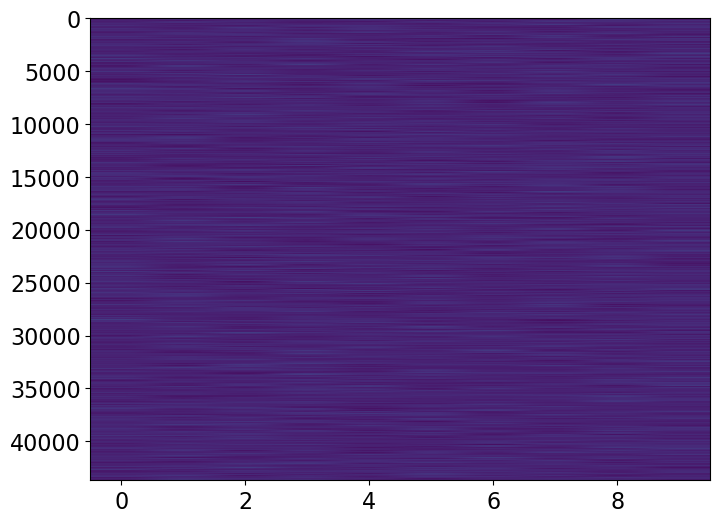

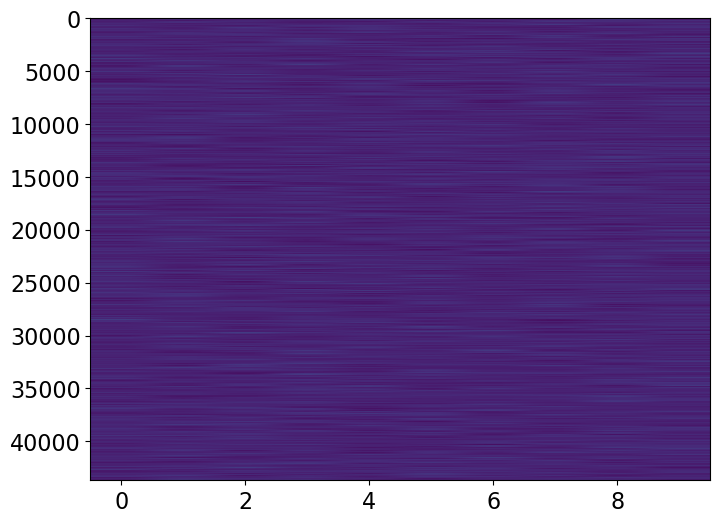

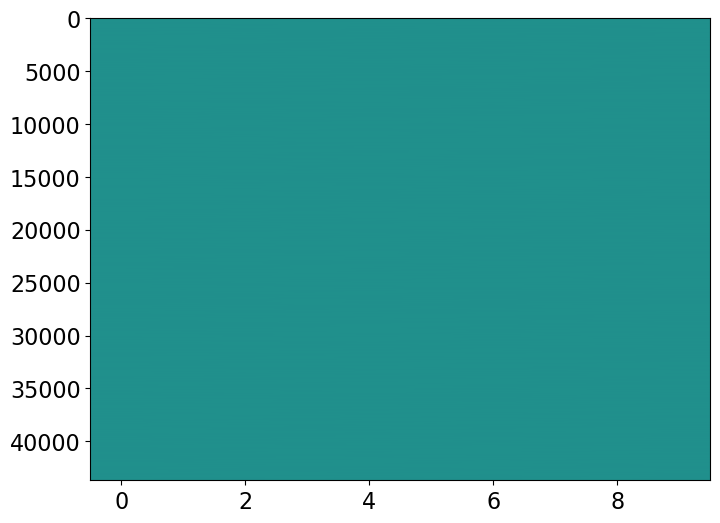

In [11]:
plt.figure()
plt.imshow(y, vmin=0, vmax=1)
plt.axis('tight')
plt.figure()
plt.imshow(y1, vmin=0, vmax=1)
plt.axis('tight')
plt.figure()
plt.imshow(y-y1, vmin=-0.1, vmax=0.1)
plt.axis('tight');

In [12]:
#%timeit -n 3 -r 2 s.prox(x, 1.).reshape(x.shape)
%timeit -n 5 -r 2 s1.prox(x, 1.).reshape(x.shape)
%timeit -n 5 -r 2 simplex_jit1(x, coeffs, 1., lower, upper, 20, 1e-3, 1e-3)

2.1 s ± 546 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)
94.8 ms ± 35.8 µs per loop (mean ± std. dev. of 2 runs, 5 loops each)


In [13]:
n1, n2 = 43690, n
x = np.random.normal(0., 1., (n1, n2))
s = Simplex(n1, 1., dims=(n1, n2), axis=1, engine='numpy', maxiter=20, xtol=1e-3)
s1 = Simplex(n1, 1., dims=(n1, n2), axis=1, engine='numba', 
             maxiter=20, xtol=1e-3, ftol=1e-3)

y = s.prox(x.ravel(), 1.).reshape(x.shape)
y1 = s1.prox(x.ravel(), 1.).reshape(x.shape)
y2 = simplex_jit1(x, coeffs, 1., lower, upper, 20, 1e-3, 1e-3)

## Simplex vectorized

In [14]:
def fun(mu, x, coeffs, scalar, lower, upper):
    """Bisection function"""
    f = np.dot(np.minimum(np.maximum(x - mu[:, np.newaxis] * coeffs.T, lower), upper), coeffs) - scalar
    return f.ravel()

def bisect(x, coeffs, scalar, lower, upper, bisect_lower, bisect_upper, maxiter):
    n = x.shape[0]
    a, b = bisect_lower * np.ones(n), bisect_upper * np.ones(n)
    fa = fun(a, x, coeffs, scalar, lower, upper)
    for iiter in range(maxiter):
        c = (a + b) / 2.
        fc = fun(c, x, coeffs, scalar, lower, upper)
        mask = np.sign(fc) == np.sign(fa)
        a[mask] = c[mask]
        fa[mask] = fc[mask]
        b[~mask] = c[~mask]
    return c

def simplex(x, coeffs, scalar, lower, upper, maxiter):
    y = np.zeros_like(x)
    bisect_lower = -10
    bisect_upper = 10
    c = bisect(x, coeffs, scalar, lower, upper, bisect_lower, bisect_upper, maxiter)
    y = np.minimum(np.maximum(x - c[:, np.newaxis] * coeffs.T, lower), upper)
    return y

In [15]:
y3 = simplex(x, coeffs[:, np.newaxis], 1., lower, upper, 20)
np.allclose(y3, y2, rtol=1e-5, atol=1e-5)

%timeit -n 5 -r 2 simplex(x, coeffs[:, np.newaxis], 1., lower, upper, 20)

138 ms ± 22.3 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


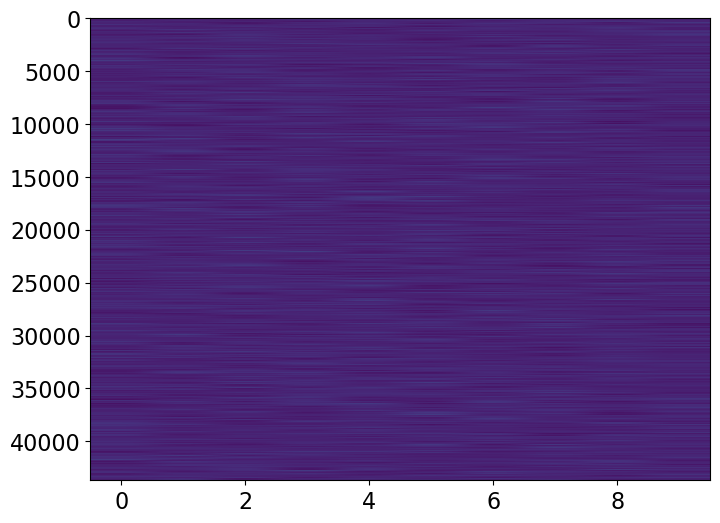

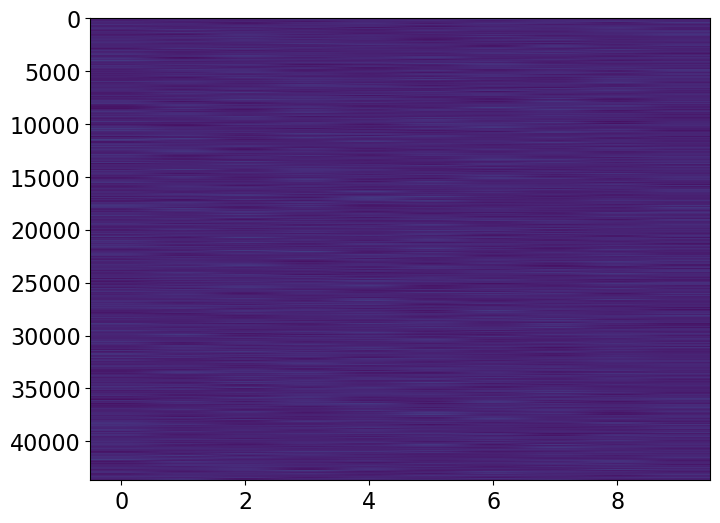

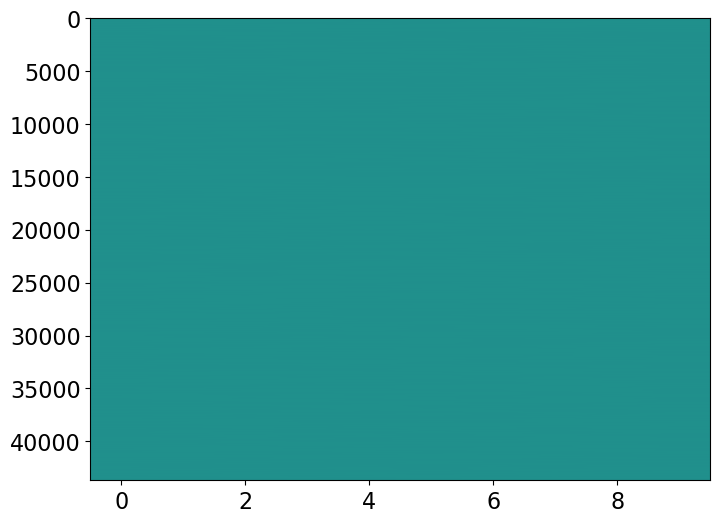

In [16]:
plt.figure()
plt.imshow(y, vmin=0, vmax=1)
plt.axis('tight')
plt.figure()
plt.imshow(y3, vmin=0, vmax=1)
plt.axis('tight')
plt.figure()
plt.imshow(y-y3, vmin=-0.1, vmax=0.1)
plt.axis('tight');